# プロダクト課題演習
## BERTによるニュース分類（TensorFlow）
### 【前提】
- コーディング演習11-2の結果に対して詳細分析

In [17]:
import sys
import tarfile
import os
from tqdm import tqdm
import glob
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from keras import initializers
from transformers import BertJapaneseTokenizer, TFBertModel
%matplotlib inline

random_state = 42
import matplotlib.pyplot as plt

### データセットの用意

まずは元データのLivedoorニュースコーパスをダウンロードしましょう。

以下のURLをブラウザで入力すると、自動的に圧縮ファイルがダウンロードされます。

https://www.rondhuit.com/download/ldcc-20140209.tar.gz

※ダウンロードが終わったら「ldcc-20140209.tar.gz」のファイルを<font color="Red">このノートブックと同じフォルダ</font>に移動させてください。(Google colabの場合はマイドライブに移動させてください)

In [4]:
# Pathの設定
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マイドライブ内のデータを読み込むpathに設定
    livedoor_path = '/content/drive/MyDrive/ldcc-20140209.tar.gz'
else:
    livedoor_path = 'ldcc-20140209.tar.gz'
    
save_path = './data/livedoor/'
tar = tarfile.open(livedoor_path)
tar.extractall(save_path)
tar.close()

#### データセットの作成

* <font color="Red">問1. ```os.listdir```と```os.path.isdir```を使って、リスト```category_list```にニュースのカテゴリーを抽出・格納しよう。Livedoorニューコーパスののディレクトリ構造は以下の通りになっています。</font><br>

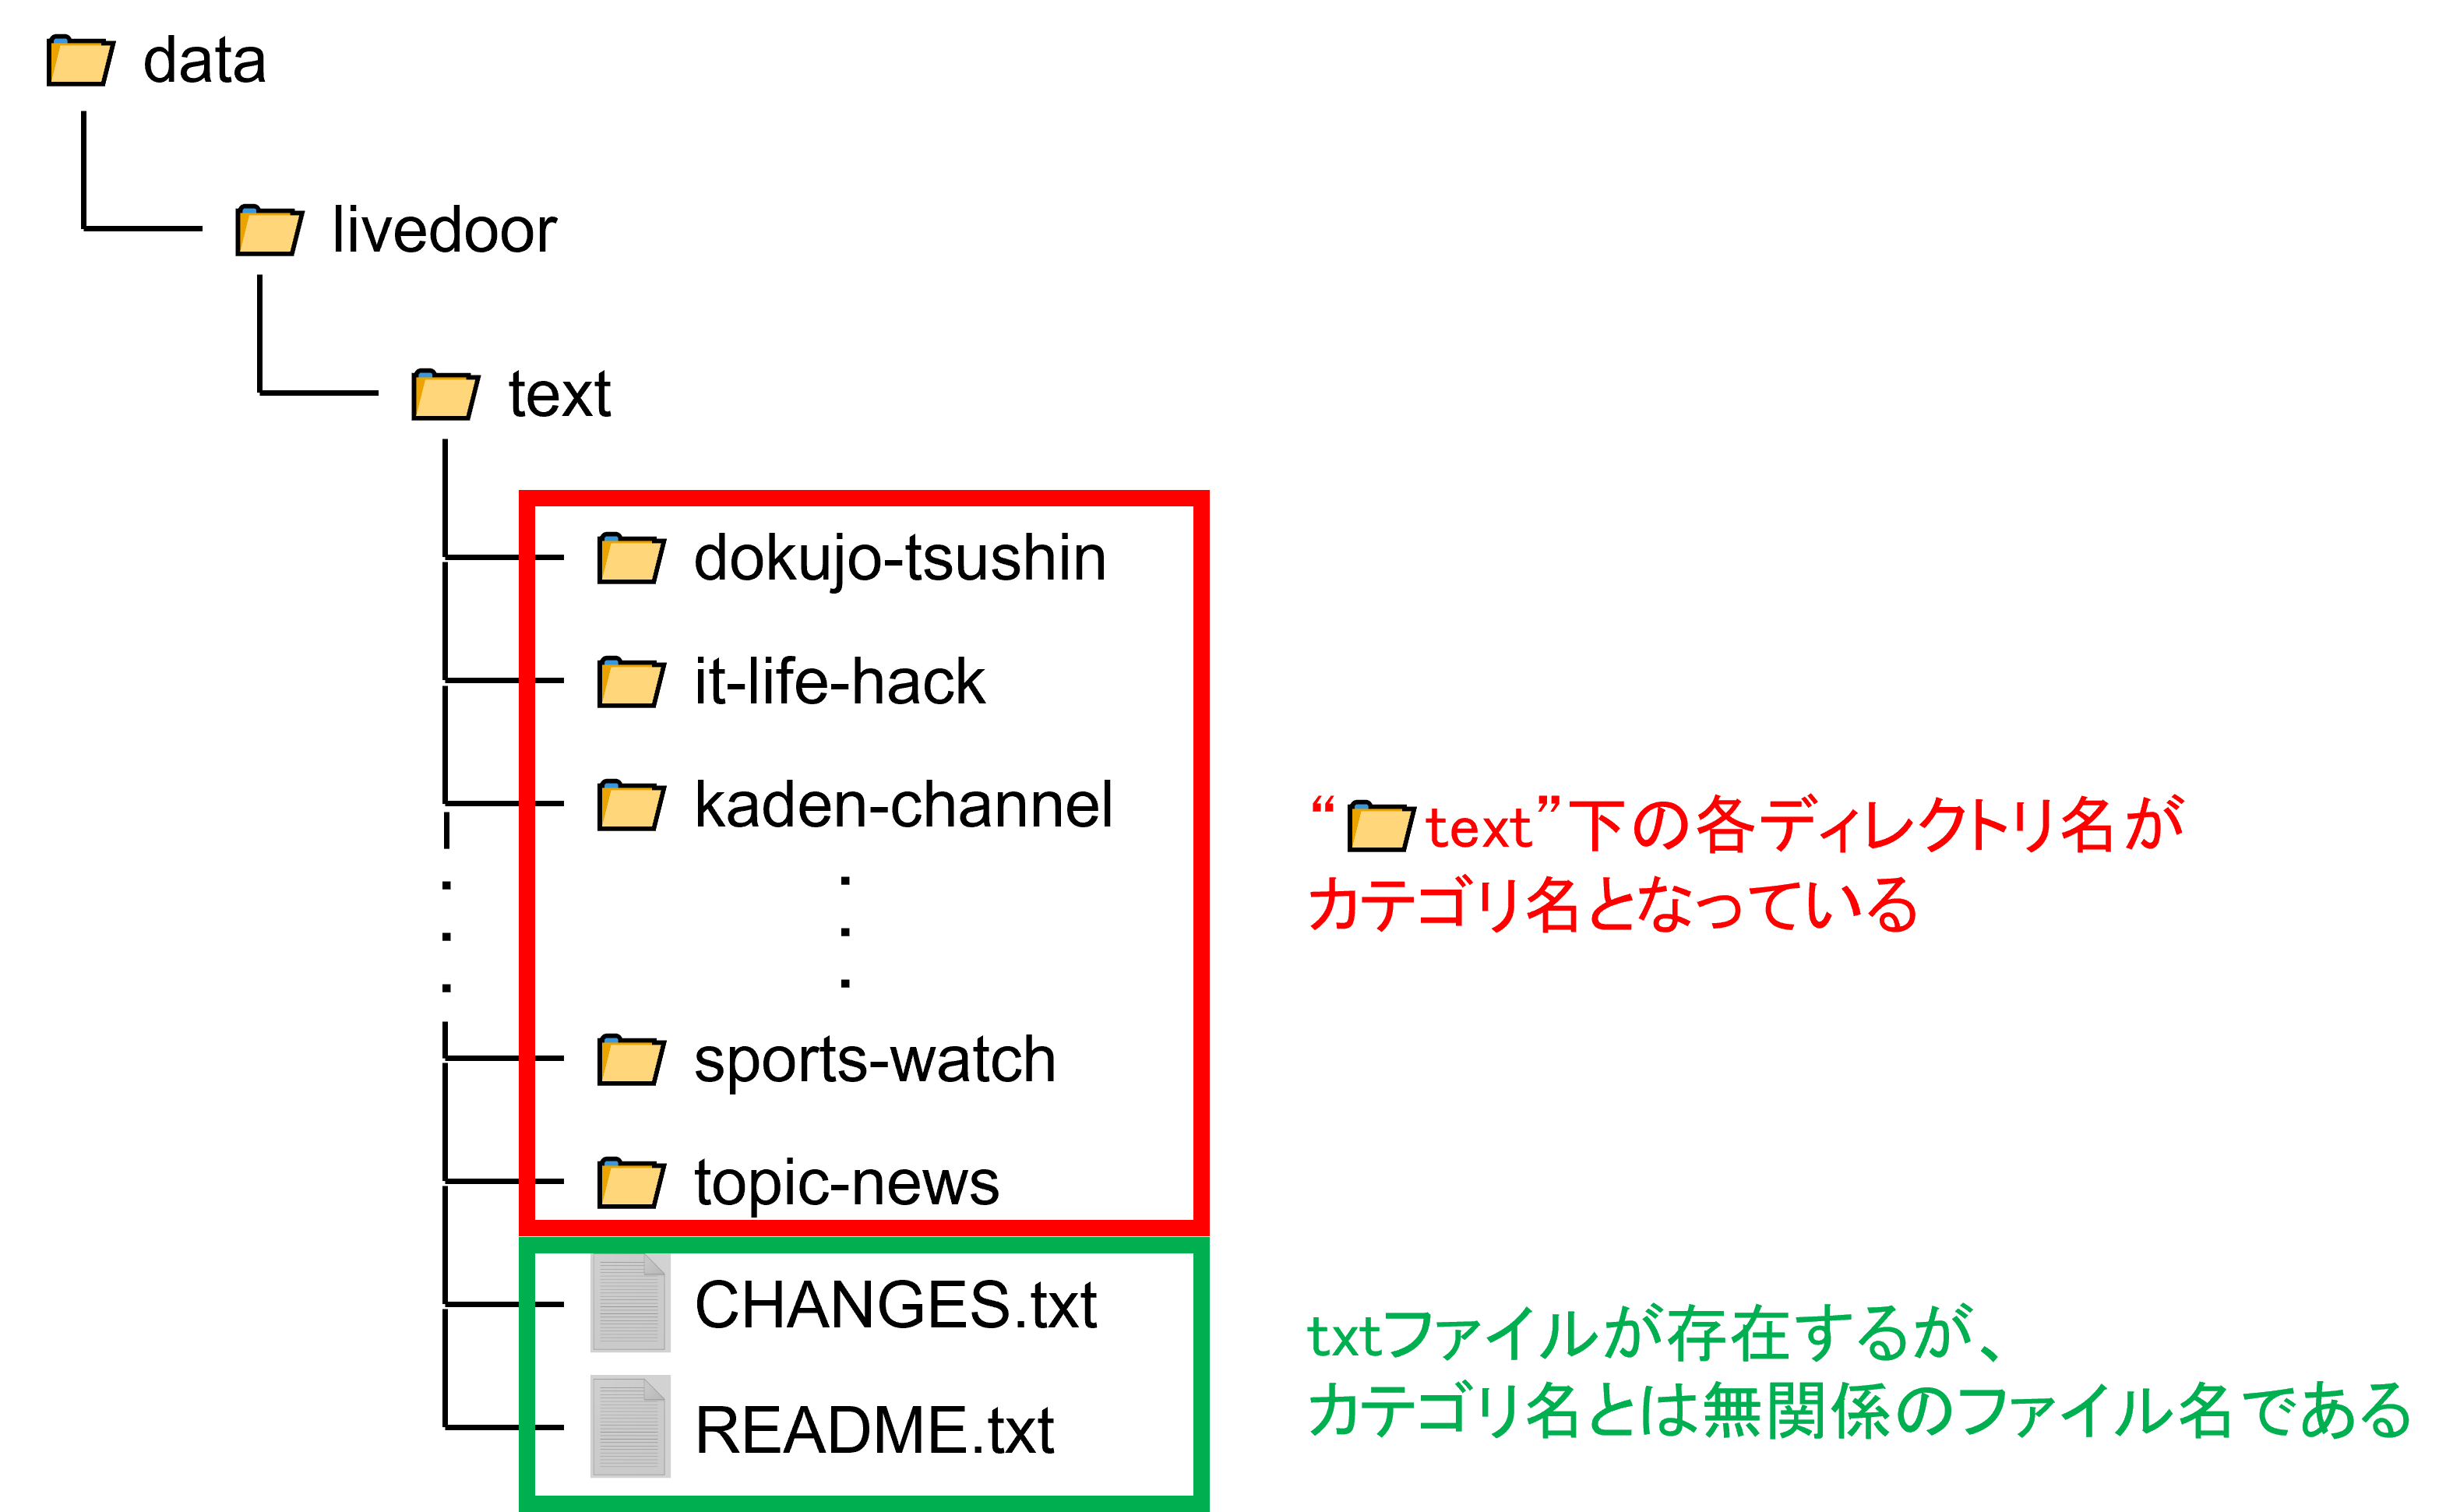

In [5]:
# work
for name in os.listdir('./data/livedoor/text'):
    print(name)

CHANGES.txt
dokujo-tsushin
it-life-hack
kaden-channel
livedoor-homme
movie-enter
peachy
README.txt
smax
sports-watch
topic-news


In [6]:
# カテゴリーのフォルダのみを抽出
category_list =  [name for name in os.listdir('./data/livedoor/text') if os.path.isdir('./data/livedoor/text/'+ name)]### 問1 ###
print("カテゴリー数: ", len(category_list))
print(category_list)

カテゴリー数:  9
['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


In [7]:
for name in os.listdir("./data/livedoor/text/"):
    if os.path.isdir("./data/livedoor/text" + name):### ワーク1-2 ### :
        print(name)

In [8]:
# ファイルの中身を確認してみる
# 例: movie-enter
file_name = "./data/livedoor/text/movie-enter/movie-enter-6255260.txt"

with open(file_name, encoding="utf-8_sig") as text_file:
    text = text_file.readlines()
    print("0：", text[0])  # URL情報
    print("1：", text[1])  # タイムスタンプ
    print("2：", text[2])  # タイトル
    print("3：", text[3:])  # 本文

0： http://news.livedoor.com/article/detail/6255260/

1： 2012-02-07T09:00:00+0900

2： 新しいヴァンパイアが誕生！　ジョニデ主演『ダーク・シャドウ』の公開日が決定

3： ['\u3000こんなヴァンパイアは見たことがない！\u3000ジョニー・デップとティム・バートン監督がタッグを組んだ映画『ダーク・シャドウズ（原題）』の邦題が『ダーク・シャドウ』に決定。日本公開日が5月19日に決まった。さらに、ジョニー・デップ演じるヴァンパイアの写真が公開された。\n', '\n', '\u3000本作は、1966年から1971年にアメリカのABCテレビで放送されたカルト的人気ドラマ「ダーク・シャドウズ」をベースに映画化した作品。主人公は、1752年にイギリスからアメリカに移民し、裕福なコリンズ家に育ったプレイボーイのバーバナス・コリンズ。ある日、バーバナスは、魔女のアンジェリークによって死よりも恐ろしい運命となるヴァンパイアにされ、生き埋めにされてしまう。それから2世紀後の1972年、予期せぬきっかけで自分の墓から開放される。劇的な変化を遂げた世の中で、バーバナスと不可思議な謎を秘めるコリンズ家の末裔との姿を描く。\n', '\n', '\u3000かねてより同テレビシリーズの熱狂的ファンと公言していたジョニー・デップが、主人公のバーバナスで自身初となるヴァンパイアを演じる。子供時代からの夢であった役を射止めた彼は「僕はずっと『ダーク・シャドウズ』に魅了されてきた。家に走っては帰ってテレビにかじりついて見ていた。子供の頃からジョナサン・フリットが演じたヴァンパイア一家の家長のバーバナスを演じたかったんだ」とコメントしている。\n', '\n', '\u3000その他、エバ・グリーン、ミシェル・ファイファー、ヘレナ・ボナム＝カーターら豪華演技派俳優が集結。さらに、『トレインスポッティング』のジョニー・リー・ミラー、『キック・アス』のクロエ・モレッツ、『ヒューゴの不思議な発明』のデイビッド・コリンズらが不思議なコリンズ一家の一員を演じる。\n', '\n', '\u3000ヴァンパイアの「ニンニク嫌い」「十字架に弱い」「日光に当たると灰になる」「昼間は棺桶で寝ている」などのイメージを覆す、家族思いで

### Tokenizerの用意

BERTはニューラルネットワークを用いた言語モデルが実装されていますが、一から実装するのは非常に手間がかかります。

そのため実際上は学習済みモデルを使用します。

今回は東北大学の研究チームによって作成されたBERTの日本語の事前学習モデル```cl-tohoku/bert-base-japanese-whole-word-masking```を用います。

この事前学習モデルはWikipediaの日本語記事のデータを用いて学習されています。


* <font color="Red">問2. スライド11章で紹介されているBERTの関数を参考に、```bert-base-japanese-whole-word-masking```モデルのTokenizerを呼び出そう。<br>ただし、日本語のTokenizerを呼び出す為、```BertTokenizer```の代わりに```BertJapaneseTokenizer```を使用しよう。</font><br>

In [9]:
print(category_list)

['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


In [11]:
# トークナイザの用意
tokenizer =  BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')### 問2 ###

# データローダの為のデータセットを作成
n_label = 2 # 学習にかかる時間を短縮するためカテゴリ数を減らす
max_length = 40
category_list = category_list[:n_label] # n_labelクラスだけ分類
dataset = []
for label, category in enumerate(tqdm(category_list)):
    for f in glob.glob(f'./data/livedoor/text/{category}/{category}*'):
        lines = open(f, encoding="utf-8_sig").read().splitlines()
        text = lines[2] # タイトルのみ抽出
        encoding = tokenizer(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True
        )
        encoding['label'] = label
        encoding = { k: np.array(v) for k, v in encoding.items() }
        dataset.append(encoding)

input_ids = []
attention_mask = []
token_type_ids = []
label = []
for batch in dataset:
    input_ids.append(batch['input_ids'])
    attention_mask.append(batch['attention_mask'])
    token_type_ids.append(batch['token_type_ids'])
    label.append(batch['label'])

input_ids = np.array(input_ids)
attention_mask = np.array(attention_mask)
token_type_ids = np.array(token_type_ids)
label = tf.keras.utils.to_categorical(label, num_classes=n_label)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.38s/it]


In [12]:
# データの確認
print('input_ids: ', input_ids.shape)
print('attention_mask: ', attention_mask.shape)
print('token_type_ids: ', token_type_ids.shape)
print('label: ', label.shape)

input_ids:  (1740, 40)
attention_mask:  (1740, 40)
token_type_ids:  (1740, 40)
label:  (1740, 2)


In [13]:
print(dataset)

[{'input_ids': array([    2,  3676,   542,     5, 22130,     6,   569,   335,     9,
        1704, 12056,    16,    33,  2935,     3,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0]), 'token_type_ids': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'label': array(0)}, {'input_ids': array([    2,  1920,    12, 24934, 11145,    80,   281,   103, 28507,
          13,     5,  2855,     3,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0]), 'token_ty

### BERTクラスの用意

#### 学習済みモデルの用意
* <font color="Red">問3. スライド11章で紹介されているBERTの関数を参考に、```bert-base-japanese-whole-word-masking```モデルを呼び出そう。ただし、TensorFlow
用のBERTモデルの呼び出すため、```BertModel```の代わりに```TFBertModel```を使用しよう。</font><br>

In [14]:
model_bert =  TFBertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')### 問3 ###
print(model_bert)

Some layers from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### 分類器の用意

BERTモデルを組み込んだ分類器を用意する。

In [53]:
class BertClassifier:
    def __init__(self, model_bert, n_label, max_length):
        super(BertClassifier, self).__init__()
        input_shape = (max_length, )
        self.input_ids = Input(shape=input_shape, dtype = tf.int32)
        self.attention_mask = Input(shape=input_shape, dtype = tf.int32)
        self.token_type_ids = Input(shape=input_shape, dtype = tf.int32)
        self.model_bert = model_bert
        # ファインチューニングの設定
        # 全ての勾配計算をFalseに
        self.model_bert.trainable = False
        # BertModelの最後のレイヤのみ勾配計算ありに変更
        self.model_bert.layers[-1].trainable = True
        self.dense = Dense(
            n_label,
            kernel_initializer = initializers.RandomNormal(stddev=0.02, seed=0),
            bias_initializer = initializers.RandomNormal(mean=0.0, seed=0),
        )
    
    def  __call__(self):
        output_bert  = self.model_bert(
            self.input_ids,
            self.attention_mask,
            self.token_type_ids
        )
        output_bert = output_bert[0]
        output_bert = tf.reshape(output_bert[:, 0, :], [-1, 768])
        output = self.dense(output_bert)
        model = Model(
            [self.input_ids, self.attention_mask, self.token_type_ids],
            output
        )
        return model


### 学習，評価


事前学習モデルの最後のレイヤと、追加した新しい層の重みをファインチューニングによって調整します。

ファインチューニングを復習しておきましょう。

ファインチューニングは事前学習済みモデルの重みを初期値として、再学習で微調整する手法です。

今回は事前学習済みモデルの最後のレイヤの重みのみ微調整します。


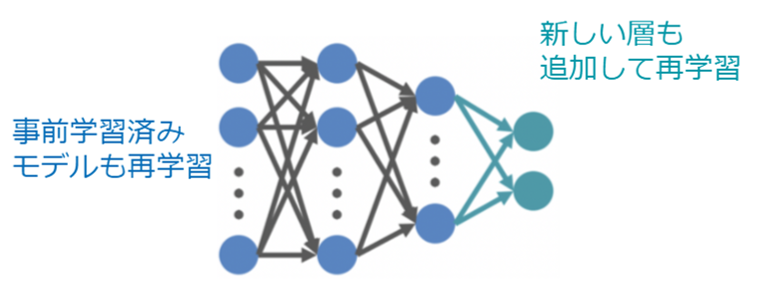

モデルの設定をファインチューニング用に変更して学習させる。

In [16]:
model = BertClassifier(model_bert, n_label, max_length)()

batch_size = 8
n_epochs = 5
model.compile(
    loss='categorical_crossentropy',
    optimizer = "Adam"
)

history = model.fit(
    x = [input_ids, attention_mask, token_type_ids],
    y = label,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    validation_split=0.2
)

Epoch 1/5
174/174 [==============================] - 80s 427ms/step - loss: 6.6169 - val_loss: 9.6801
Epoch 2/5
174/174 [==============================] - 95s 547ms/step - loss: 6.7738 - val_loss: 9.6801
Epoch 3/5
174/174 [==============================] - 95s 547ms/step - loss: 6.8432 - val_loss: 9.6801
Epoch 4/5
174/174 [==============================] - 90s 515ms/step - loss: 6.9127 - val_loss: 9.6801
Epoch 5/5
174/174 [==============================] - 94s 543ms/step - loss: 6.8664 - val_loss: 9.6801


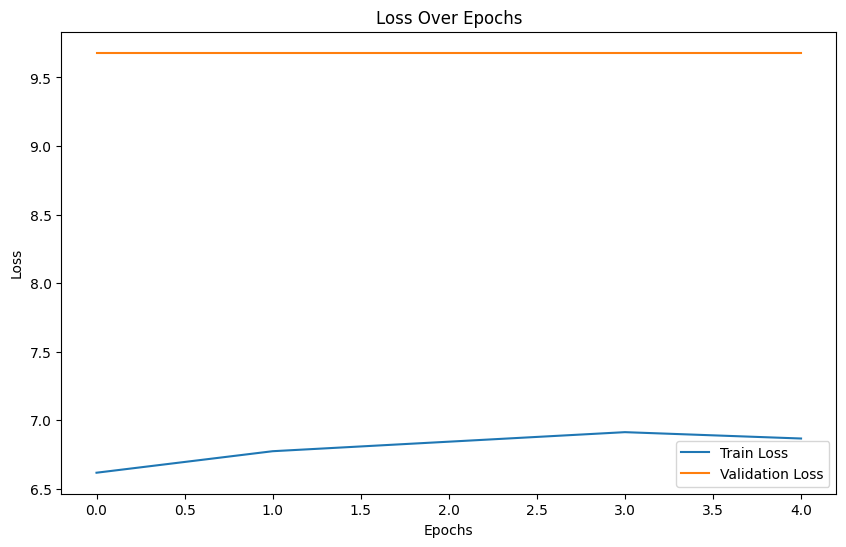

In [18]:
plt.figure(figsize=(10, 6)) 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# モデル予測結果確認

In [19]:
test_text = '家族内のコミュニケーションについて'

In [25]:
# 予測を行うテキストデータ
text = "家族内のコミュニケーションについて"

# トークナイザを用いてテキストをトークン化
encoding = tokenizer(
    text,
    max_length=max_length,
    padding='max_length',
    truncation=True
)

# モデルによる予測
predictions = model.predict([np.array([encoding['input_ids']]), np.array([encoding['attention_mask']]), np.array([encoding['token_type_ids']])])

# 予測結果の表示
print("Predictions:", predictions)
predicted_label = np.argmax(predictions)
print(f'The predicted label is: {predicted_label}')

Predictions: [[ 0.50730515 -0.6580483 ]]
The predicted label is: 0


In [26]:
test_text = 'AIを活用した仕事の効率化について'

In [27]:
# 予測を行うテキストデータ
text = "AIを活用した仕事の効率化について"

# トークナイザを用いてテキストをトークン化
encoding = tokenizer(
    text,
    max_length=max_length,
    padding='max_length',
    truncation=True
)

# モデルによる予測
predictions = model.predict([np.array([encoding['input_ids']]), np.array([encoding['attention_mask']]), np.array([encoding['token_type_ids']])])

# 予測結果の表示
print("Predictions:", predictions)
predicted_label = np.argmax(predictions)
print(f'The predicted label is: {predicted_label}')

Predictions: [[ 0.57321656 -0.60006416]]
The predicted label is: 0


# 現状分析

## データの中身
- 'label': array(0)
　- 独女通信
  - 普段の日常で独身女性の微妙な心理に関する記事
- 'label': array(1)
  - ライフハック
  　- さまざまなテーマについてのアイデアやアドバイスを提供する記事。
    - 例:時間管理、ストレス解消、健康維持、家事の効率化など

## 1. 訓練誤差と検証誤差に乖離がある（検証誤差のみ異様に誤差があるのでハイパーパラメータの調整が必要）
### (1)学習率の変更
- Before:Adam(leaarning_rate=0.001)#デフォルト
- After:tf.keras.optimizers.Adam(learning_rate=2e-5)
- 変更理由：現状より誤差を下げるため。BERTにおける学習率は2e-5、3e-5、5e-5などが一般的に使用されるそうです。
- [参考記事](https://ai-scholar.tech/articles/bert/bert-fine-tuning)
### (2)バッチサイズとエポック数  
- Before:
  - batch_size = 8
  - n_epochs = 5
- After:
  - batch_size = 10
  - n_epochs = 10
- 変更理由：バッチサイス、エポック数を増やすことでより精度が良くなるため。※過学習対策として早期終了を導入
## 2. テキスト分類タスクの誤り回答
- 先ほどの検証例だと「AIを活用した仕事の効率化について」というライフハックに関する記事なのでラベル0ではなく1に分類したいが分類できていない。
  - ⇒性能指標の導入により数値として精度を示す。
  - ⇒今回は2つのカテゴリ分類になるので損失関数は「バイナリクロスエントロピー」が妥当

In [67]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

class FixBertClassifier:
    def __init__(self, model_bert, n_label, max_length, dropout_rate=0.1):
        super(FixBertClassifier, self).__init__()
        input_shape = (max_length, )
        self.input_ids = Input(shape=input_shape, dtype = tf.int32)
        self.attention_mask = Input(shape=input_shape, dtype = tf.int32)
        self.token_type_ids = Input(shape=input_shape, dtype = tf.int32)
        self.model_bert = model_bert
        # ファインチューニングの設定
        # 全ての勾配計算をFalseに
        self.model_bert.trainable = False
        # BertModelの最後のレイヤのみ勾配計算ありに変更
        self.model_bert.layers[-1].trainable = True
        self.dropout = Dropout(dropout_rate)  # ドロップアウトを追加
        self.dense = Dense(
            n_label,
            kernel_initializer = initializers.RandomNormal(stddev=0.02, seed=0),
            bias_initializer = initializers.RandomNormal(mean=0.0, seed=0),
        )
#         self.activation = Activation('sigmoid')# 全結合層の後にsigmoid関数を適用し、0~1を出力
    
    def  __call__(self):
        output_bert  = self.model_bert(
            self.input_ids,
            self.attention_mask,
            self.token_type_ids
        )
        output_bert = output_bert[0]
        output_bert = tf.reshape(output_bert[:, 0, :], [-1, 768])
        output_bert = self.dropout(output_bert)  # ドロップアウトを追加
        output = self.dense(output_bert)
#         output = self.activation(output) # sigmoid関数を適用し、0~1を出力
        model = Model(
            [self.input_ids, self.attention_mask, self.token_type_ids],
            output
        )
        return model


In [68]:
# 早期停止のコールバックを設定
early_stopping = EarlyStopping(
    monitor='val_loss',  # 監視対象
    patience=3,  # 改善が見られないエポック数
    verbose=1  # 途中経過の表示
)
model = FixBertClassifier(model_bert, n_label, max_length)()

batch_size = 10
n_epochs = 10

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# 損失関数の変更及び
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy'
             )
#               metrics=['accuracy', tf.keras.metrics.AUC()])

# モデルの学習
history = model.fit(
    x = [input_ids, attention_mask, token_type_ids],
    y = label,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]  # 早期停止を追加
)

Epoch 1/10
140/140 [==============================] - 113s 673ms/step - loss: 0.5124 - accuracy: 0.8333 - val_loss: 0.3826 - val_accuracy: 0.8046
Epoch 2/10
140/140 [==============================] - 101s 725ms/step - loss: 0.2991 - accuracy: 0.9282 - val_loss: 0.1564 - val_accuracy: 0.9885
Epoch 3/10
140/140 [==============================] - 105s 751ms/step - loss: 0.3787 - accuracy: 0.9310 - val_loss: 0.3218 - val_accuracy: 0.9224
Epoch 4/10
140/140 [==============================] - 107s 762ms/step - loss: 0.2301 - accuracy: 0.9461 - val_loss: 0.3612 - val_accuracy: 0.8822
Epoch 5/10
140/140 [==============================] - 113s 806ms/step - loss: 0.2037 - accuracy: 0.9533 - val_loss: 0.2482 - val_accuracy: 0.9253
Epoch 5: early stopping


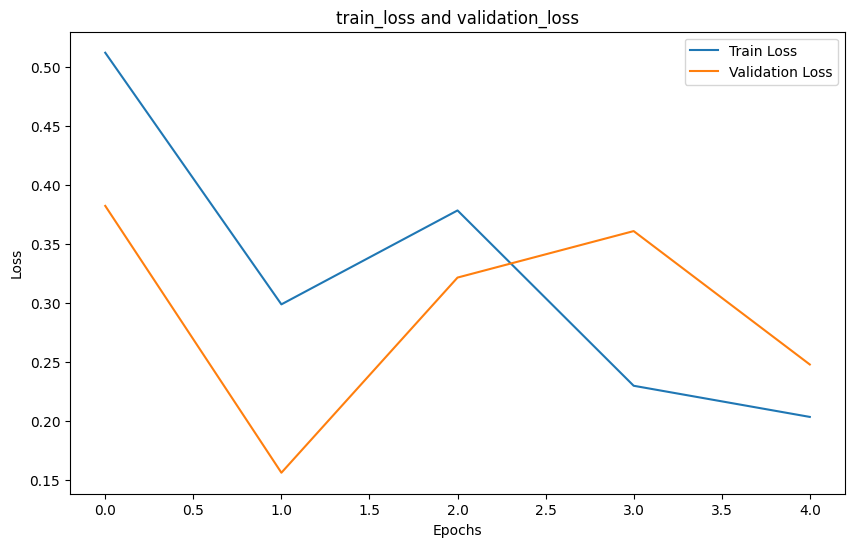

In [69]:
plt.figure(figsize=(10, 6)) 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('train_loss and validation_loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
# 予測を行うテキストデータ
text = "家族内のコミュニケーションについて"

# トークナイザを用いてテキストをトークン化
encoding = tokenizer(
    text,
    max_length=max_length,
    padding='max_length',
    truncation=True
)

# モデルによる予測
predictions = model.predict([np.array([encoding['input_ids']]), np.array([encoding['attention_mask']]), np.array([encoding['token_type_ids']])])

# 予測結果の表示
print("Predictions:", predictions)
predicted_label = np.argmax(predictions)
print(f'The predicted label is: {predicted_label}')

Predictions: [[ 0.3726562  -0.00695488]]
The predicted label is: 0


# 結果考察
## 未知のデータに対するテキスト分類について
- 上記の結果から汎化性能を向上させることができた。
  - Before:text = "AIを活用した仕事の効率化について"⇒　ラベル"0"
  - After：text = "AIを活用した仕事の効率化について"⇒　ラベル"1"
## 精度向上について
- ハイパーパラメータの改良により訓練誤差・検証誤差を下げることに成功した。
　- Before:loss: 6.8664 - val_loss: 9.6801
  - After:loss: 0.2037 - accuracy: 0.9533 - val_loss: 0.2482 - val_accuracy: 0.9253

## 以上です。ご確認の程よろしくお願いいたします。